In [1]:
import os
import json
import glob
import shutil
from math import dist
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from matplotlib.font_manager import FontProperties
from typing import Union
import sys
sys.path.append(os.path.abspath("../code_base"))
from _info_ import ear_types, degrees, acupoints_name, cm, rotation_angles
from _common_ import angles, split_xy_xyv
from prediction import pred_csv
# from matplotlib.font_manager import FontProperties
# from ..code_base._info_ import ear_types, degrees, acupoints_name, cm, rotation_angles
# from ..code_base._common_ import angles, split_xy_xyvm
# from ..code_base.prediction import pred_csv

In [4]:
class rotation_errors():
    def __init__(self):
        self.rotation_csv = "../rotation_csv"
        
    def read_error_csv(self, fpath1):
        error_np = pd.read_csv(fpath1, index_col = 0).to_numpy()
        return error_np

    def wrap_err_from_csv(self):
        result = {}
        for ear_type in ear_types:
            result[ear_type] = []
            names = os.listdir(os.path.join(self.rotation_csv, ear_type))
            for name in names:
                deg_err = []
                for deg in degrees:
                    angles_err = []
                    for angle in rotation_angles:
                        csv_pth = os.path.join(self.rotation_csv, ear_type, name, deg, str(angle), "error.csv")
                        error_np = self.read_error_csv(csv_pth)
                        angles_err.append(error_np)
                    deg_err.append(angles_err)
                result[ear_type].append(deg_err)             #shape = (subjects, degrees, angles, acupoints)      
            print(np.array(result[ear_type]).shape)
        return result 

In [132]:
class plot_fig():
    def __init__(self, errors: Union[dict, list]):
        self.wrapped_errors = errors
        self.occluded_result = "../occluded_result" 
        
    def unwrapped_to_CDF(self, wrapped_errors_dict):
        CDF = {}
        for ear_type in ear_types:
            CDF[ear_type]= {}
            total = np.array(wrapped_errors_dict[ear_type])
            total = total.reshape(-1)
            
            sorted_error = np.sort(total*10)
            cumulative_prob = np.arange(1, len(total) + 1) / len(total)
            
            CDF[ear_type]["sorted_error"] = sorted_error
            CDF[ear_type]["cumulative_prob"] = cumulative_prob
            
        return CDF
    
    def occlusion_unwrapped_to_CDF(self, wrapped_errors_dict):
        CDF = {}
        for ear_type in ear_types:
            CDF[ear_type]= {}
            total = []
            for i in range(0, len(degrees)):
                temp = []
                for j in range(4):
                    
                    total.append(wrapped_errors_dict[ear_type][i][j])         
            total = np.vstack(total)
            total = total.reshape(-1)

            sorted_error = np.sort(total*10)
            cumulative_prob = np.arange(1, len(total) + 1) / len(total)

            CDF[ear_type]["sorted_error"] = sorted_error
            CDF[ear_type]["cumulative_prob"] = cumulative_prob
            
        return CDF
        
    def CDF_fig(self, title, label):
        if isinstance(self.wrapped_errors, dict):
            CDF = self.unwrapped_to_CDF(self.wrapped_errors)
            for ear_type in ear_types: 

                plt.plot(CDF[ear_type]["sorted_error"], CDF[ear_type]["cumulative_prob"], label = label)
                plt.xlim(0, 10)
                plt.ylim(0, 1.1)
                plt.xlabel("mm")
                plt.ylabel("Probability")
                plt.title(title)
                plt.legend()
                plt.show()
        elif isinstance(self.wrapped_errors, list):
            for ear_type in ear_types:
                for i in range(0, len(self.wrapped_errors)):
                    CDF = self.unwrapped_to_CDF(self.wrapped_errors[i])
                    plt.plot(CDF[ear_type]["sorted_error"], CDF[ear_type]["cumulative_prob"], label = label[i])
                plt.xlim(0, 10)
                plt.ylim(0, 1.1)
                plt.xlabel("mm")
                plt.ylabel("Probability")
                plt.title(title)
                plt.legend()
                plt.show()

        else:
            raise ValueError("Unsupported type")
    def bar_fig(self, label, plot_type = "acupoints"):
        
        if isinstance(self.wrapped_errors, dict):
            if plot_type == "acupoints":
                permute_dim = (1, 2, 3, 0)
                title = "Acupoint localization error"
            else:
                permute_dim = (1, 2, 0, 3)
                title = "Acupoint localization error on different subjects"
            for ear_type in ear_types:
                x = np.transpose(self.wrapped_errors[ear_type], permute_dim)*10
                means = np.nanmean(x, axis = 3)
                stds = np.nanstd(x, axis = 3)
                if plot_type == "acupoints":
                    tick_label = acupoints_name[:x.shape[2]]
                else:
                    tick_label = ["Subject"+str(x) for x in list(range(0 , x.shape[2]))]
                
                for i in range(0, len(x)):
                    plt.figure(figsize=(15,10))
                    for j in range(0 ,len(x[0])):

                        plt.bar(np.arange(x.shape[2]) + j*0.2, means[i][j], yerr=stds[i][j], align='center', label = '{index} degrees'.format(index = 0 + 10*j), ecolor='black', capsize=3, width=0.2)

                    plt.ylabel('mm' , fontsize = 30, labelpad = 50, rotation = 0)

                    plt.rcParams['font.sans-serif'] = ['Microsoft JhengHei'] 

                    font_path = r'C:\Windows\Fonts\msjhl.ttc'
                    font = FontProperties(fname=font_path, size=12)
                    
                    plt.xticks(np.arange(x.shape[2]) + 0.3, tick_label, fontsize=12, rotation=-45, ha='center')
         
                    plt.yticks(fontsize=30)
                    plt.title(title, fontsize = 30, pad = 20)

                    plt.legend(fontsize=17, ncol = 1, loc = (1.001,0))

                    plt.tight_layout()

                    if not os.path.isdir(os.path.join(traditional_inpainting, ear_type, "figure", deg)):
                        os.makedirs(os.path.join(traditional_inpainting, ear_type, "figure", deg))
                    plt.savefig(os.path.join(traditional_inpainting, ear_type, "figure", deg,'different acupoints.png').format(index = 0))

                    plt.show()
        else:
            raise ValueError("Unsupported type")
            
            
    def comparison_bar_fig(self, label, plot_type = "acupoints"):
        if plot_type == "acupoints":
            permute_dim = (2, 4, 0, 1, 3)
            title = "Acupoint localization error"
            x_tick_rotation = -45
            x_tick_fontsize = 15
#         else:
#             permute_dim = (0, 1, 2, 3)
#             title = "Acupoint localization error on different subjects"
#             x_tick_rotation = 0
#             x_tick_fontsize = 20
        if isinstance(self.wrapped_errors, dict):
            
            
            
            for ear_type in ear_types:
                plt.figure(figsize=(20,90))
                for_arrange = 0
                means = []
                stds = []
                tick_label = []
                    
#                 for i in range(0, len(self.wrapped_errors)):
                x = np.transpose(self.wrapped_errors[ear_type], permute_dim)*10

                means = np.nanmean(x, axis = (2, 3, 4))
                stds = np.nanstd(x, axis = (2, 3, 4))
                print(means.shape)
            
                for i in range(0, len(means)):
#                     plt.bar(np.arange(len(means[i])) + i*0.3, means[i], yerr=stds[i], align='center', label = label[i], ecolor='black', capsize=3, width=0.2)
                    plt.barh(np.arange(len(means[i])) + i*0.1, means[i], xerr=stds[i], align='center', label = label[i], ecolor='black', capsize=3, height = 0.1)
#                 for j in range(0, len(means)):
#                     if plot_type == "acupoints":
#                         tick_label = acupoints_name[:len(means[j])]
#                     else:
#                         tick_label = ["Subject"+str(x) for x in list(range(len(means[j])))]
#                     plt.bar(np.arange(len(means[j])) + j*0.2, means[j], yerr=stds[j], align='center', label = label[j], ecolor='black', capsize=3, width=0.2)
                plt.ylabel('mm' , fontsize = 30, labelpad = 50, rotation = 0)

                plt.rcParams['font.sans-serif'] = ['Microsoft JhengHei'] 

                font_path = r'C:\Windows\Fonts\msjhl.ttc'
                font = FontProperties(fname=font_path, size=12)

                plt.xticks(np.arange(len(tick_label)) + 0.5, tick_label, fontsize=x_tick_fontsize, rotation=x_tick_rotation, ha='center')

                plt.yticks(fontsize=30)
                plt.title(title, fontsize = 30, pad = 20)

                plt.legend(fontsize=17, ncol = 1, loc = (1.001,0))

                plt.tight_layout()
        #                 if not os.path.isdir(os.path.join(traditional_inpainting, ear_type, "figure", deg)):
        #                     os.makedirs(os.path.join(traditional_inpainting, ear_type, "figure", deg))
        #                 plt.savefig(os.path.join(traditional_inpainting, ear_type, "figure", deg,'different acupoints.png').format(index = 0))

                plt.show()
        else:
            raise ValueError("Unsupported type")
        
#
        
        
            
    
    def bar_fig_total(self, title, label):
        if isinstance(self.wrapped_errors, list):
            plt.figure(figsize=(15,10))
            for i in range(0, len(self.wrapped_errors)): 
                
                means = []
                stds = []
                for ear_type in ear_types:
                    means.append(np.nanmean(self.wrapped_errors[i][ear_type], axis = (0, 1, 2, 3)))
                    stds.append(np.nanstd(self.wrapped_errors[i][ear_type], axis = (0, 1, 2, 3)))
                plt.bar(np.arange(len(ear_types)) + i*0.2, means, yerr=stds, align='center', label = label[i], ecolor='black', capsize=3, width=0.2)
            plt.ylabel('mm' , fontsize = 30, labelpad = 50, rotation = 0)

            plt.rcParams['font.sans-serif'] = ['Microsoft JhengHei'] 

            font_path = r'C:\Windows\Fonts\msjhl.ttc'
            font = FontProperties(fname=font_path, size=12)

            plt.xticks(np.arange(len(ear_types)) + 0.1, ear_types, fontsize=20, rotation=0, ha='center')

            plt.yticks(fontsize=30)
            plt.title(title, fontsize = 30, pad = 20)

            plt.legend(fontsize=17, ncol = 1, loc = (1.001,0))

            plt.tight_layout()
    #                 if not os.path.isdir(os.path.join(traditional_inpainting, ear_type, "figure", deg)):
    #                     os.makedirs(os.path.join(traditional_inpainting, ear_type, "figure", deg))
    #                 plt.savefig(os.path.join(traditional_inpainting, ear_type, "figure", deg,'different acupoints.png').format(index = 0))

            plt.show()
        else:
            raise ValueError("Unsupported type")

In [133]:
A = rotation_errors()
print(type(A.wrap_err_from_csv()))

(8, 6, 7, 4, 21)
(5, 6, 7, 4, 14)
<class 'dict'>


(8, 6, 7, 4, 21)
(5, 6, 7, 4, 14)
(7, 21)


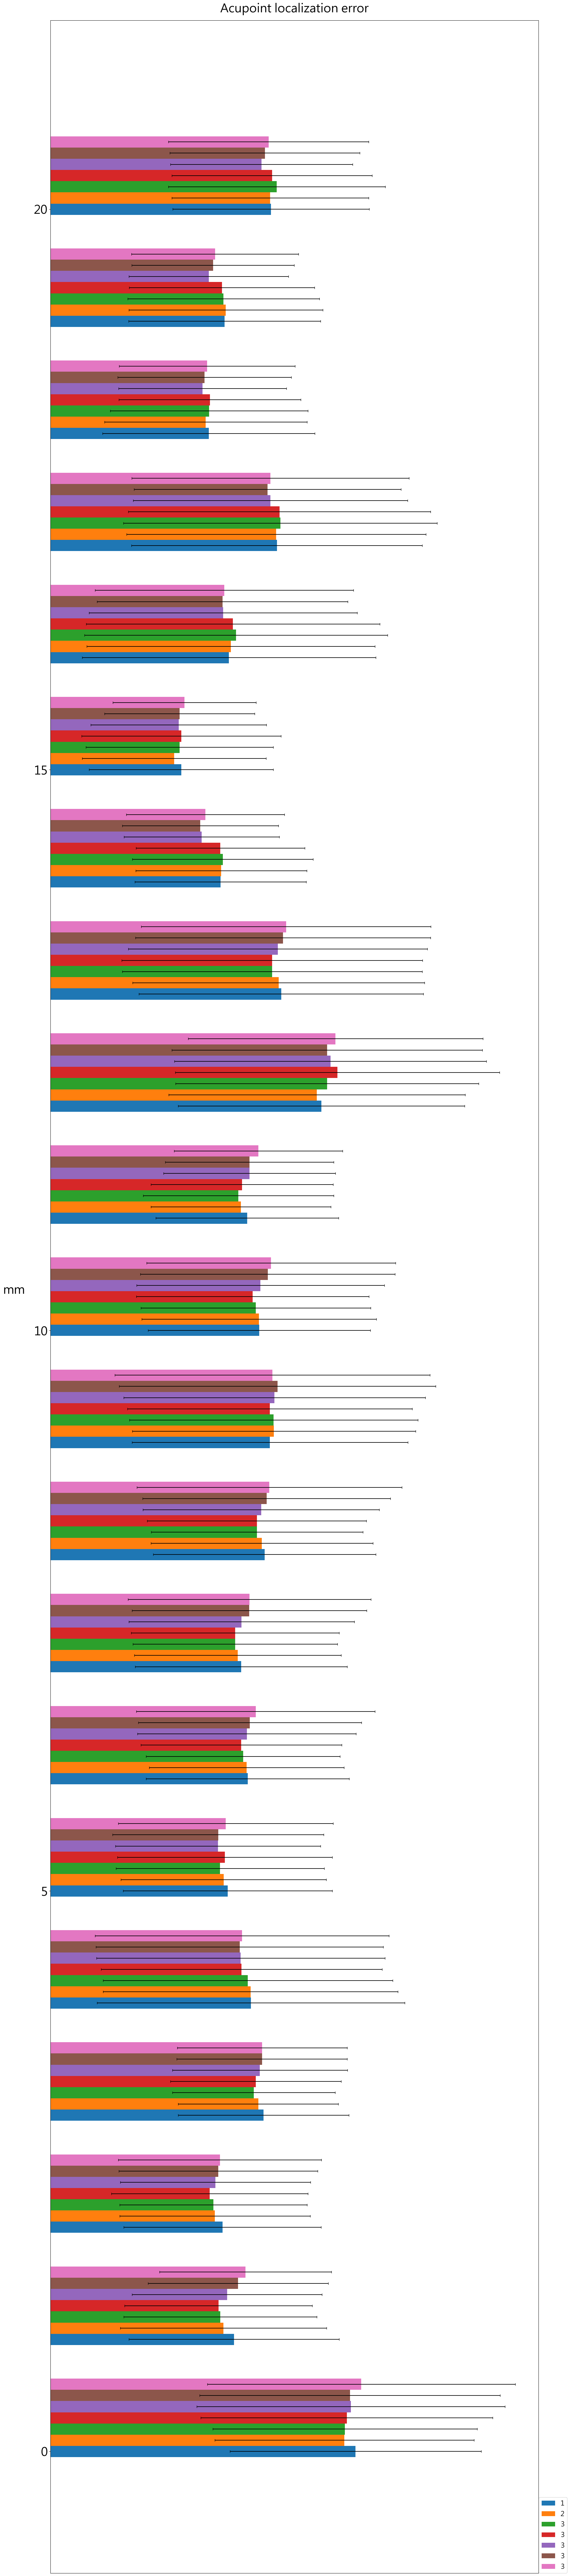

(7, 14)


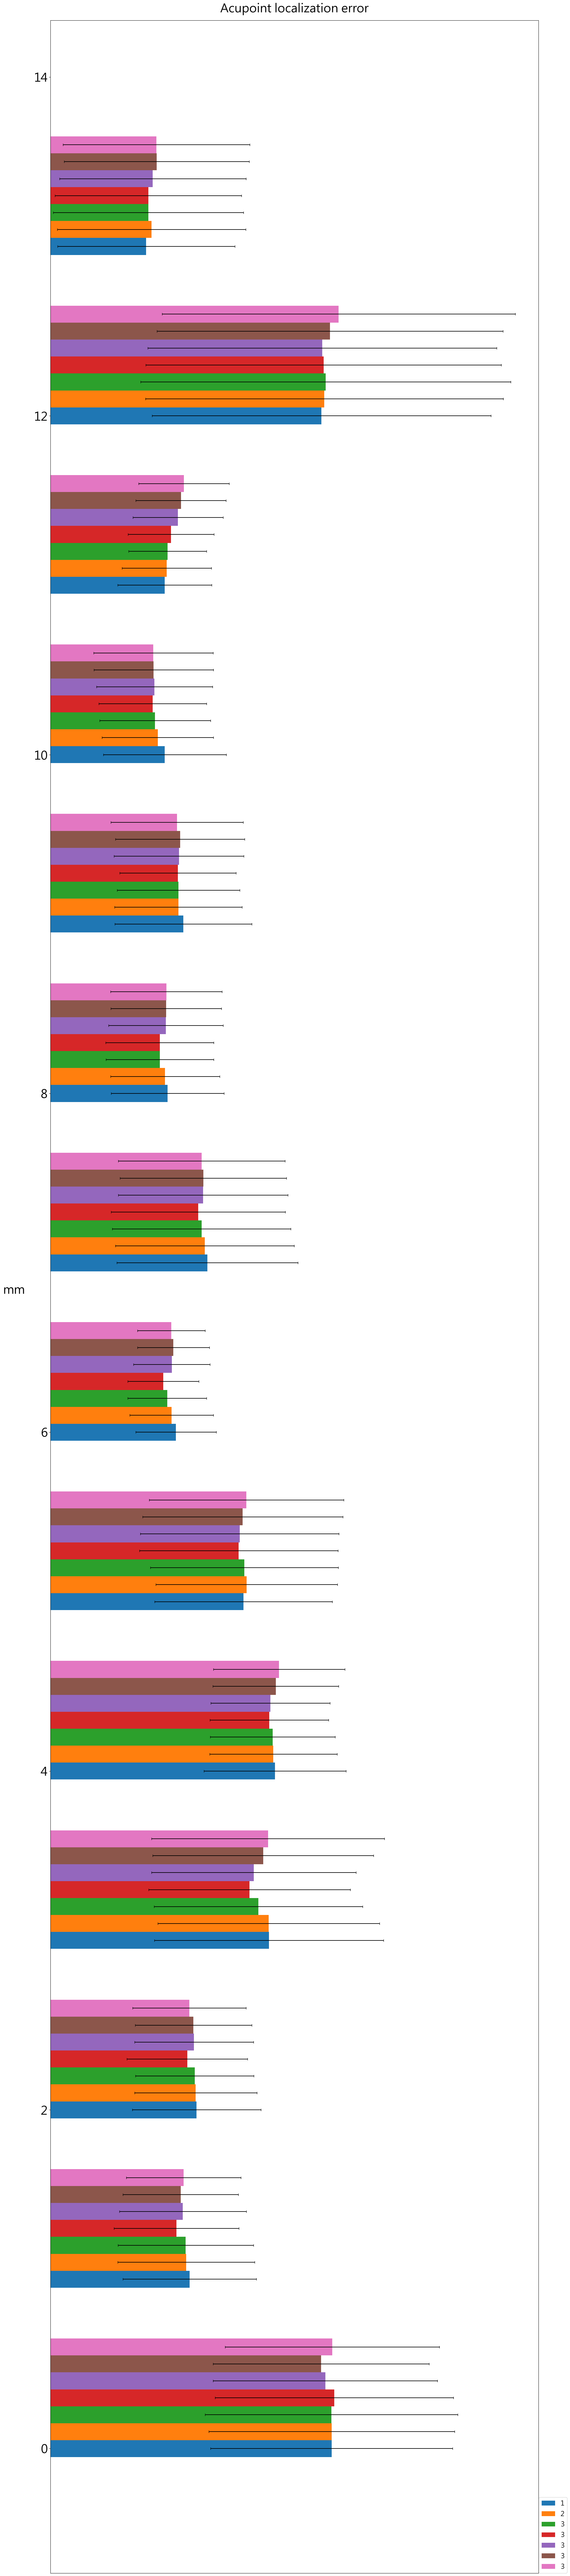

In [134]:
B = plot_fig(A.wrap_err_from_csv())
B.comparison_bar_fig("1233333333")